In [1]:
import scipy
scipy.__version__

'1.0.0'

In [3]:
from __future__ import print_function, division

In [5]:
import os
import time

import numpy as np
import pandas as pd

import scipy.sparse as sparse

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
DATA_DIR = '/Users/appry001/Data/ml-20m/pro/'

In [9]:
unique_uid = list()
with open(os.path.join(DATA_DIR, 'unique_uid.txt'), 'r') as f:
    for line in f:
        unique_uid.append(line.strip())
    
unique_sid = list()
with open(os.path.join(DATA_DIR, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

In [10]:
n_items = len(unique_sid)
n_users = len(unique_uid)
print(n_users, n_items)

111148 11711


In [11]:
def load_data(csv_file, shape=(n_users, n_items)):
    tp = pd.read_csv(csv_file)
    print(tp.head())
    timestamps, rows, cols = np.array(tp['timestamp']), np.array(tp['uid']), np.array(tp['sid'])
    #seq = np.concatenate((rows[:, None], cols[:, None], np.ones((rows.size, 1), dtype='int'), timestamps[:, None]), axis=1)
    data = sparse.csr_matrix((np.ones_like(rows), (rows, cols)), dtype=np.int16, shape=shape)
    return data #, seq

In [12]:
train_data = load_data(os.path.join(DATA_DIR, 'train.csv'))

   timestamp     uid   sid
0  789652004   22802  1151
1  789652009  105277    46
2  822873600   87053    56
3  822873600   68348    69
4  822873600   80133     0


In [13]:
vad_data = load_data(os.path.join(DATA_DIR, 'validation.csv'))

   timestamp     uid  sid
0  822873600   80133   20
1  822873600   80133   17
2  822873600  107905   10
3  822873600  107905   20
4  823185198   99550   49


In [14]:
test_data = load_data(os.path.join(DATA_DIR, 'test.csv'))

    timestamp    uid    sid
0  1255949513  24501   1167
1  1255949516  66083  10339
2  1255949525  66083   5097
3  1255949529  66083  10343
4  1255949531  24501   1186


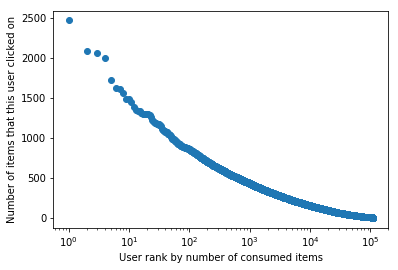

In [15]:
user_activity = np.asarray(train_data.sum(axis=1)).ravel()
plt.semilogx(1 + np.arange(n_users), -np.sort(-user_activity), 'o')
plt.ylabel('Number of items that this user clicked on')
plt.xlabel('User rank by number of consumed items')
pass

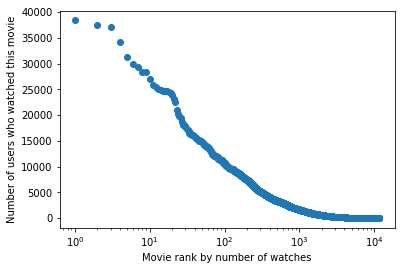

In [16]:
watches_per_movie = np.asarray(train_data.astype('int64').sum(axis=0)).ravel()
plt.semilogx(1 + np.arange(n_items), -np.sort(-watches_per_movie), 'o')
plt.ylabel('Number of users who watched this movie')
plt.xlabel('Movie rank by number of watches')
pass

In [17]:
def linear_surplus_confidence_matrix(B, alpha):
    # To construct the surplus confidence matrix, we need to operate only on
    # the nonzero elements.
    # This is not possible: S = alpha * B
    S = B.copy()
    S.data = alpha * S.data
    return S

In [18]:
#recompute_factors=batched_inv_joblib.recompute_factors_batched
def get_row(S, i):
    """
    Args:
        S: scipy.sparse.csr_matrix
        i: index to the ith row in S
        
    Returns:
        S.data[lo:hi]: the non-zero elements in row i of S
        S.indices[lo:hi]: the column indices of the non-zero elements in row i of S
    """
    lo, hi = S.indptr[i], S.indptr[i + 1]
    return S.data[lo:hi], S.indices[lo:hi]

def solve_sequential(As, Bs):
    """
    """
    X_stack = np.empty_like(As, dtype=As.dtype)
    for k in xrange(As.shape[0]):
        X_stack[k] = np.linalg.solve(Bs[k], As[k])
    return X_stack

def recompute_factors_full(Y, S, lambda_reg):
    
    m = S.shape[0]  # m = number of users
    f = Y.shape[1]  # f = number of factors

    YTY = np.dot(Y.T, Y)  # precompute this
    YTYpR = YTY + lambda_reg * np.eye(f)

    A_stack = np.empty((m, f), dtype='float32')
    B_stack = np.empty((m, f, f), dtype='float32')

    for u in xrange(m):
        s_u, i_u = get_row(S, u)
        # i_u indexes the nz item elements for user u
        Y_u = Y[i_u]  # exploit sparsity
        A = (s_u + 1).dot(Y_u)
        YTSY = np.dot(Y_u.T, (Y_u * s_u[:, None]))
        B = YTSY + YTYpR
        A_stack[u] = A
        B_stack[u] = B
        #if u == 0:
        #    print('i_u ', i_u)
        #    print('s_u ', s_u.shape)
        #    print('Y_u ', Y_u.shape)
        #    print('A ', A.shape)
        #    print('YTSY ', YTSY.shape)
        #    print('B ', B.shape)
    X_stack = solve_sequential(A_stack, B_stack)
    
    return X_stack

In [19]:
import bottleneck as bn
import numpy as np

from scipy import sparse

def normalized_dcg_at_k(train_data, heldout_data, U, V, batch_users=5000,
                        k=100, mu=None, vad_data=None, agg=np.nanmean):

    n_users = train_data.shape[0]
    res = list()
    for user_idx in user_idx_generator(n_users, batch_users):
        res.append(NDCG_binary_at_k_batch(train_data, heldout_data, U, V.T,
                                          user_idx, k=k, mu=mu,
                                          vad_data=vad_data))
    ndcg = np.hstack(res)
    if callable(agg):
        return agg(ndcg)
    return ndcg

def user_idx_generator(n_users, batch_users):
    ''' helper function to generate the user index to loop through the dataset
    '''
    for start in xrange(0, n_users, batch_users):
        end = min(n_users, start + batch_users)
        yield slice(start, end)

def _make_prediction(train_data, Et, Eb, user_idx, batch_users, mu=None,
                     vad_data=None):
    n_songs = train_data.shape[1]
    # exclude examples from training and validation (if any)
    item_idx = np.zeros((batch_users, n_songs), dtype=bool)
    item_idx[train_data[user_idx].nonzero()] = True
    if vad_data is not None:
        item_idx[vad_data[user_idx].nonzero()] = True
    X_pred = Et[user_idx].dot(Eb)
    if mu is not None:
        if isinstance(mu, np.ndarray):
            assert mu.size == n_songs  # mu_i
            X_pred *= mu
        elif isinstance(mu, dict):  # func(mu_ui)
            params, func = mu['params'], mu['func']
            args = [params[0][user_idx], params[1]]
            if len(params) > 2:  # for bias term in document or length-scale
                args += [params[2][user_idx]]
            if not callable(func):
                raise TypeError("expecting a callable function")
            X_pred *= func(*args)
        else:
            raise ValueError("unsupported mu type")
    X_pred[item_idx] = -np.inf
    return X_pred

def NDCG_binary_at_k_batch(train_data, heldout_data, Et, Eb, user_idx,
                           mu=None, k=100, vad_data=None):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = user_idx.stop - user_idx.start # just a number

    X_pred = _make_prediction(train_data, Et, Eb, user_idx,
                              batch_users, mu=mu, vad_data=vad_data)
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted
    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    heldout_batch = heldout_data[user_idx]
    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG

In [26]:
# summarize WMF_ML20M
num_factors = 100
num_iters = 15
#lam_theta = lam_beta = 1e-5
lambda_U_reg = 1e-5
lambda_V_reg = 1e-5
alpha = 10
init_std=0.01

S = linear_surplus_confidence_matrix(train_data, alpha=alpha)

num_users, num_items = S.shape

ST = S.T.tocsr()

random_state=98765
if type(random_state) is int:
    np.random.seed(random_state)
elif random_state is not None:
    np.random.setstate(random_state)
V = np.random.randn(num_items, num_factors).astype('float32') * init_std

old_ndcg = -np.inf

for i in xrange(num_iters):
    print("Iteration %d:" % i)
    
    print('\tUpdating user factors...')
    start_time = time.time()
    U = recompute_factors_full(V, S, lambda_U_reg)
    print('\t\tUser update time=%.2fs' % (time.time() - start_time))
    
    print('\tUpdating item factors...')
    start_time = time.time()
    V = recompute_factors_full(U, ST, lambda_V_reg)
    print('\t\tItem update time=%.2fs' % (time.time() - start_time))

    print('\tComputing NDCG on validation data...')
    start_time = time.time()
    vad_ndcg = normalized_dcg_at_k(S, vad_data, U, V, k=100, batch_users=5000)
    print('\t\tNDCG computed in %.2fs' % (time.time()-start_time))
    print("\tValidation NDCG@k: %.5f" % vad_ndcg)
    if old_ndcg > vad_ndcg:
        print('\t\t NDCG has gone down. Early stopping.')
        break
    old_ndcg = vad_ndcg


Iteration 0:
	Updating user factors...
		User update time=48.47s
	Updating item factors...
		Item update time=10.11s
	Computing NDCG on validation data...


/Users/appry001/Envs/cofactorEnv/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


		NDCG computed in 29.71s
	Validation NDCG@k: 0.19087
Iteration 1:
	Updating user factors...
		User update time=47.86s
	Updating item factors...
		Item update time=10.09s
	Computing NDCG on validation data...
		NDCG computed in 30.95s
	Validation NDCG@k: 0.31009
Iteration 2:
	Updating user factors...
		User update time=48.43s
	Updating item factors...
		Item update time=10.11s
	Computing NDCG on validation data...
		NDCG computed in 29.09s
	Validation NDCG@k: 0.32825
Iteration 3:
	Updating user factors...
		User update time=47.14s
	Updating item factors...
		Item update time=9.85s
	Computing NDCG on validation data...
		NDCG computed in 28.10s
	Validation NDCG@k: 0.33675
Iteration 4:
	Updating user factors...
		User update time=47.21s
	Updating item factors...
		Item update time=9.81s
	Computing NDCG on validation data...
		NDCG computed in 27.70s
	Validation NDCG@k: 0.34171
Iteration 5:
	Updating user factors...
		User update time=47.02s
	Updating item factors...
		Item update time=9.

In [22]:
item_idx = np.zeros((n_users, n_items), dtype=bool)
item_idx[S.nonzero()] = True

In [2]:
slice(5, 10).stop, slice(5, 10).start

(10, 5)

In [6]:
def _make_prediction(train_data, U, VT):
    n_users, n_songs = train_data.shape
    # exclude examples from training and validation (if any)
    item_idx = np.zeros((n_users, n_songs), dtype=bool)
    item_idx[train_data.nonzero()] = True
    X_pred = U.dot(VT)
    X_pred[item_idx] = -np.inf # predictions in train set get -inf
    return X_pred

X_pred = _make_prediction(S, U, V.T)
X_pred.shape

NameError: name 'S' is not defined

In [5]:
X_pred

NameError: name 'X_pred' is not defined

In [4]:
import bottleneck as bn
idx_topk_part = bn.argpartition(-X_pred, 100, axis=1)

NameError: name 'X_pred' is not defined

In [3]:
idx_topk_part

NameError: name 'idx_topk_part' is not defined

In [ ]:
# 
topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]

In [1]:
5

5

In [56]:
X_pred[:, np.newaxis].shape

(111148, 1, 11711)

In [ ]:
X_pred[idx_topk_part[:, :100]]

In [ ]:
topk_part = X_pred[[:, np.newaxis], idx_topk_part[:, :k]]

In [ ]:

def user_idx_generator(n_users, batch_users):
    ''' helper function to generate the user index to loop through the dataset
    '''
    for start in xrange(0, n_users, batch_users):
        end = min(n_users, start + batch_users)
        yield slice(start, end)

def normalized_dcg_at_k(train_data, heldout_data, U, V, k=100, agg=np.nanmean):
    """
    NDCG @ k
    """
    n_users = train_data.shape[0]
    res = list()
    for user_idx in user_idx_generator(n_users, n_users):
        res.append(NDCG_binary_at_k_batch(train_data, heldout_data, U, V.T, k=k))
        
    ndcg = np.hstack(res)
    if callable(agg):
        return agg(ndcg)
    return ndcg

def NDCG_binary_at_k_batch(train_data, heldout_data, U, VT, k=100):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    #batch_users = user_idx.stop - user_idx.start

    X_pred = _make_prediction(train_data, U, VT)
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted
    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    heldout_batch = heldout_data
    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis], idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG


In [36]:
vad_data

<111148x11711 sparse matrix of type '<type 'numpy.int16'>'
	with 999003 stored elements in Compressed Sparse Row format>

In [16]:
U[0]

array([ 0.47483447, -0.45262411,  0.12922375, -0.37676117, -1.82800055,
        0.5996694 , -0.82891166,  0.38306516,  0.10334159, -0.58245152,
        0.06795751, -1.05457795,  1.27783525, -0.58131236, -0.29370022,
        0.32481018,  0.37592852,  0.29745358,  1.30121052, -0.00357365,
        0.66819078, -0.98151368,  0.3816582 , -0.57974958, -1.92892361,
        0.53237849, -0.07437876, -0.22442238,  0.53737158, -1.11361492,
       -0.52870733, -0.10714696,  0.07809896,  0.22033608, -0.36906809,
       -0.37337652,  0.70809895, -0.84612507,  1.29883635,  0.08175272,
       -0.55716425, -0.32196003,  0.11929715, -0.47686729, -0.11620339,
       -1.2678771 ,  0.03485085,  0.29723802, -0.76723731, -0.31596872,
        1.06023335,  0.97439206,  0.77322119, -0.72154772, -0.17960925,
       -0.61731648, -0.33738431,  0.95407182, -0.84338319,  0.72571206,
        0.82911766, -0.14987759,  0.14903134,  0.7739957 ,  0.35197195,
       -1.52633965, -0.02371887,  0.74461204,  0.72278631, -0.78